## Optimization Project 2 - Integer Programming

Submitted By: Group 6
- Apurva Audi (AA85254)
- Soumya Agrawal (SA55638)
- Troy Austin (TA23234)
- Vivek Dhulipalla (VD6543)

### Problem Statement

Evaluating the stock selection and MIP methods to optimize the portfolio funds

### Importing relevant libraries

In [14]:
import pandas as pd
import numpy as np
import gurobipy as gp

import matplotlib.pyplot as plt
import seaborn as sn

gurobi_time_limit =3600

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
#Importing csv files
stocks2019 = pd.read_csv("stocks2019.csv")
stocks2020 = pd.read_csv("stocks2020.csv")

In [16]:
print(stocks2019.shape)
print(stocks2020.shape)

(251, 102)
(189, 102)


In [17]:
'''
Function for generic optimizer
'''
def calculate(obj, A, b, sense, rule, vtype = None, ub = None, lb = None,time_limit=3600):
    Model = gp.Model()
    ModX = Model.addMVar(len(obj), vtype = vtype, ub = ub, lb = lb) 
    ModCon = Model.addMConstrs(A, ModX, sense, b)
    if rule == 'Max':
        Model.setMObjective(None, obj, 0, sense = gp.GRB.MAXIMIZE)
    else:
        Model.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)  
    Model.Params.OutputFlag = 0
    Model.Params.TimeLimit = time_limit
    Model.optimize()
    return Model.objVal, ModX.x

'''
Function to return similarity matrix of daily returns

'''

def return_sim(df):    
    df.rename(columns={df.columns[0]: 'Date'}, inplace = True) 
    df.set_index('Date', inplace = True)
    Ret_df = df.pct_change()[1:] 
    Corr_Sim = Ret_df.iloc[:,1:].corr()
    return Ret_df, Corr_Sim

In [18]:
'''
Function to select the top m stocks from the list of stocks

'''

def select_stocks(m, p, df):    
    df_stocks = df.iloc[:, 1:]                             # Filter out Index from Input DataFrame
    n = len(p)
    obj = np.zeros(n*n + n)                                # Objective contains (n*n) X_ij and n y_j Decision Variables
    obj[:n*n] = p.to_numpy().flatten()                     # Setting X_ij Coefficients to p_ij
    #addinf constrains 
    A = np.zeros((n**2 + n + 1, n**2 + n))
    b = np.zeros(n**2 + n + 1)
    sense = np.array([''] * (n**2 + n + 1))
    
    # Select exactly m Stocks to be held in the Fund
    A[0, n*n:] = 1
    b[0] = m
    sense[0] = '='
    
    # Each Stock i has exactly one representative Stock j in the Index
    for i in range(1, n+1):
        for j in range((i-1)*n, (i-1)*n + n):
            A[i,j] = 1
        b[i] = 1
        sense[i] = '='
    
    # Stock i is best represented by Stock j only if j is in the Fund
    row = i + 1
    for i in range(0, n):
        for j in range(0, n):
            A[row, i*n + j] = 1
            A[row, n*n + j] = -1
            b[row] = 0
            sense[row] = '<'
            row += 1
    
    vtype = ['B'] * len(obj)
    res_obj, res_x = calculate(obj, A, b, sense, 'Max', vtype)
    res_stocks = res_x[n*n:]                              # Extract only y_j Values
    index_stock = np.where(res_stocks == 1)[0].tolist()
    stockname = df_stocks.iloc[:,index_stock].columns.tolist()
    
    return index_stock, stockname                         # Return stock indexes and stock names

In [19]:
'''
Function to compute portfolio weights using the decision variables and linear constraints 

'''
def stockportfolioweights(m, df, stockname):
    df_stock_returns = df[stockname]
    df_index_returns = df.iloc[:,0].to_frame()
    T = len(df_stock_returns)
    obj = np.zeros(m + T)                                            # Objective contains m w_i and T d_t Decision Variables
    obj[m:] = 1                                                      # Setting y_t Coefficients to 1
    A = np.zeros((2*T + 1, m + T))
    b = np.zeros(2*T + 1)
    sense = np.array([''] * (2*T + 1))
    A[0, :m] = 1
    b[0] = 1
    sense[0] = '='
    
    # Break Non-linearity of Absolute function into Linear Constraints
    for t in range(1, T+1):
        A[t, 0:m] = df_stock_returns.iloc[t-1].tolist()
        A[t, m+t-1] = 1 
        b[t] = df_index_returns.iloc[t-1][0]
        sense[t] = '>'
        A[t+T, 0:m] = [i * (-1) for i in df_stock_returns.iloc[t-1].tolist()]
        A[t+T, m+t-1] = 1
        b[t+T] = (-1)*df_index_returns.iloc[t-1][0]
        sense[t+T] = '>'
    res_obj, res_x = calculate(obj, A, b,sense,'Min')
    
    # Extract only the Stock Weights
    weight_stock = res_x[:m]

    return weight_stock

In [20]:
'''
Function to compute abosulte deviations using Stock Selection and MIP methods

'''

def perform_measure(returnmatrix, chosen_stocks,fundweightindex):
    # Calculating the absolute deviations from the NASDAQ data
    returnweighted = np.array(returnmatrix.loc[:,chosen_stocks]) * fundweightindex
    returnweighted = returnweighted.sum(axis = 1)
    TotalAbsoluteDeviation = np.sum(np.abs(returnmatrix.iloc[:,0].to_numpy().flatten() - returnweighted))  
    return TotalAbsoluteDeviation

'''
Function to return weights of the chosen stocks

'''

def returnweighted(returnmatrix, chosen_stocks,fundweightindex):
    returnweighted = np.array(returnmatrix.loc[:,chosen_stocks]) * fundweightindex
    returnweighted = returnweighted.sum(axis = 1)
    return returnweighted

'''
Function to calculate future returns of the fund stocks and their weights

'''

def calculateFutureReturn(returns_df, fund_stocks, fund_weights, index_col='NDX'):
    return np.sum(np.abs(np.array(returns_df[index_col]) - (np.array(returns_df[fund_stocks]) @ fund_weights)))

'''
Function to compute Cumulative returns of the fund stocks and their weights

'''

def dailyCumulativeReturn(daily_return, fund_stocks, fund_weights, index_col='NDX'):
    daily_return = daily_return.T.copy()
    daily_return.insert(0, 0, 100)
    daily_return = daily_return.T
    daily_return = daily_return[[index_col] + list(fund_stocks)]
    for i in range(len(daily_return)-1):
        daily_return.iloc[i+1] = daily_return.iloc[i]*(1+daily_return.iloc[i+1])
    return daily_return[fund_stocks] @ fund_weights, daily_return[index_col]

### Question-1 : Ccomputing Returns Correlation Matrix

In [21]:
#Returns Correlation matrix
return_stock19,Corr_Sim19= return_sim(stocks2019)
display(return_stock19)

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.007454,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.002019,-0.005572,0.004090,0.029672,0.006469,0.019239,-0.000437,-0.000556,0.003638,-0.000123,...,0.002603,0.010060,-0.000104,-0.000869,-0.003217,0.003083,-0.009273,0.026019,-0.017615,0.011868
2019-12-24,0.000402,-0.001358,0.002098,0.023757,-0.001630,-0.000899,-0.004590,-0.003914,-0.002114,-0.002880,...,-0.005482,-0.002095,0.001663,-0.002541,0.002637,-0.003756,0.003502,-0.007496,0.003913,-0.004146
2019-12-26,0.009058,0.001360,0.004732,0.001934,-0.012242,0.001331,0.013418,0.012534,0.044467,-0.001774,...,0.002901,-0.004594,0.004981,-0.002279,-0.001406,0.009426,-0.004994,0.009160,-0.001114,0.001929


In [22]:
#Returns Correlation matrix in 2020
return_stock20,Corr_Sim20=return_sim(stocks2020)
display(return_stock20)

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.008827,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,...,-0.021369,-0.017207,0.021095,0.009727,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
2020-01-06,0.006211,0.018238,0.005726,-0.004321,0.001598,0.019398,0.026654,0.024657,0.014886,0.007674,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
2020-01-07,-0.000234,0.010043,-0.000959,-0.002893,0.002533,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005034,0.020414,0.067698,-0.002077,0.022830
2020-01-08,0.007452,-0.007623,0.013438,-0.008705,0.016191,0.010386,0.007118,0.007880,-0.007809,0.000756,...,-0.012323,0.019400,0.004626,0.009207,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815
2020-01-09,0.008669,-0.009018,0.007636,0.023834,0.019893,0.036853,0.010498,0.011044,0.004799,0.002980,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002244,0.023493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24,0.005828,-0.005491,-0.005782,0.014586,-0.003647,0.011546,0.009557,0.009242,0.006644,-0.009357,...,0.003254,-0.006681,0.009343,0.000847,-0.002615,-0.000856,0.006268,-0.035714,0.013295,0.017679
2020-09-25,0.023371,0.016188,0.025894,0.029544,0.021514,0.019398,0.011386,0.011671,0.024949,0.014564,...,0.086486,0.005752,0.017672,0.023190,0.019192,0.011419,0.033974,0.025047,0.021321,0.013534
2020-09-28,0.019130,0.011978,0.018196,0.018191,-0.009875,0.015507,0.013620,0.013537,0.025498,0.013165,...,0.061360,0.041092,-0.004183,0.017536,-0.001678,0.018064,0.021133,0.003899,0.005109,0.034380


### Question-2 : Choosing 5 best stocks 

In [23]:
for i in [5]: 
    stock_choices = i
    index19_selected,fund_stocks19 = select_stocks(stock_choices,Corr_Sim19,return_stock19)
    funds_weight19 = stockportfolioweights(stock_choices,return_stock19,fund_stocks19)
    funds_weight20 = stockportfolioweights(stock_choices,return_stock20,fund_stocks19)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19


Text(0.5, 0, 'Stocks Selected')

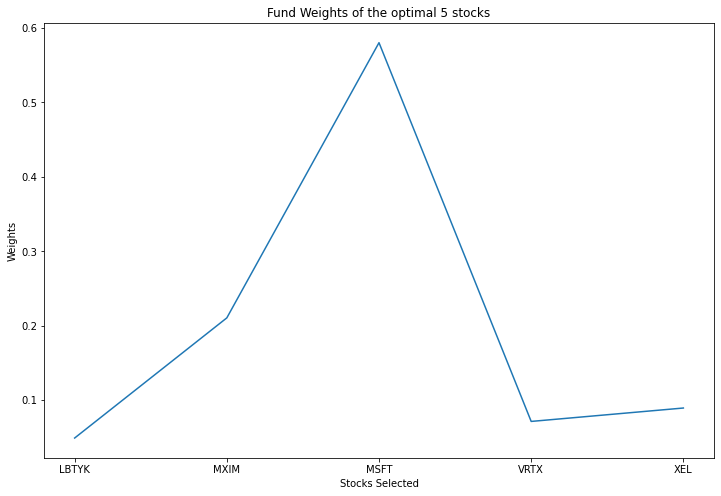

In [24]:
plt.figure(figsize = (12,8))
plt.title("Fund Weights of the optimal 5 stocks")
sn.lineplot(x = fund_stocks19, y = funds_weight19, palette= 'crest')
plt.ylabel("Weights")
plt.xlabel("Stocks Selected")

In [25]:
print("Top 5 stocks based on weights : ",fund_stocks19)
print("The corresponding weights of these stocks are : ",funds_weight19)

Top 5 stocks based on weights :  ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']
The corresponding weights of these stocks are :  [0.04886175 0.21038806 0.58035198 0.07119022 0.089208  ]


In [26]:
perform1 = perform_measure(return_stock19,fund_stocks19,funds_weight19)
perform2 = perform_measure(return_stock20,fund_stocks19,funds_weight20)

print('Total absolute deviation from NASDAQ in 2019: ',round(perform1,3))
print('Total absolute deviation from NASDAQ in 2020: ',round(perform2,3))

Total absolute deviation from NASDAQ in 2019:  0.789
Total absolute deviation from NASDAQ in 2020:  0.851


<AxesSubplot:title={'center':'Performance Evaluation on m=5'}, xlabel='Year', ylabel='Total Absolute Deviation'>

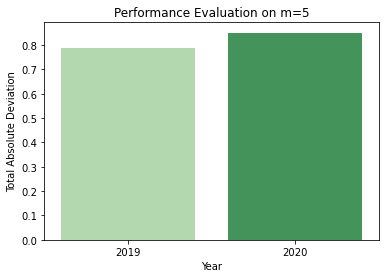

In [27]:
plt.title("Performance Evaluation on m=5")
plt.xlabel("Year")
plt.ylabel("Total Absolute Deviation")
sn.barplot(x = [2019,2020], y = [perform1,perform2], palette= 'Greens')

- Based on the portfolio developed using 2019 stock data, the total absolute deviation of the portfolio from NASDAQ is 0.7 units greater in 2020. 
- This means that portfolio returns in 2020 will be more widely distributed from the real NASDAQ returns. This issue is most likely caused by the fact that a portfolio of only 5 equities is insufficient to correctly replicate the index fund. This notion is supported by the fact that, even in 2019, variances from the NASDAQ are rather large. 
- As a result, increasing the number of stocks in the portfolio is more likely to accurately mirror the NASDAQ-100 results.

Text(0, 0.5, 'Returns')

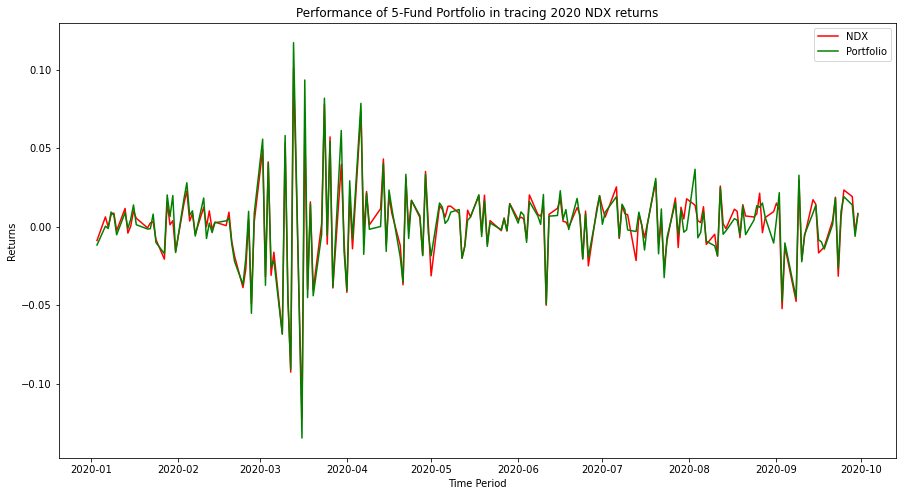

In [28]:
returntime = pd.to_datetime(stocks2020.index[1:])
plt.figure(figsize = (15,8))
sn.lineplot(x = returntime, y = return_stock20.loc[:,'NDX'], color = 'Red', label = 'NDX')
returnweighted20 = returnweighted(return_stock20,fund_stocks19,funds_weight19)

sn.lineplot(x = returntime, y = returnweighted20,
             color = 'Green', label = 'Portfolio')
plt.title("Performance of 5-Fund Portfolio in tracing 2020 NDX returns")
plt.xlabel('Time Period')
plt.ylabel('Returns')

- The graph above shows that the portoflio is somewhat accurate in monitoring the index fund in 2020. Especially when the returns are subject to big swings. For instance, between the years 2020-03 and 2020-05. 
- The most significant differences are visible around 2020-5, and lastly between 2020-07 and 2020-08 when the line (portfolio) clearly does not overlap with the botted line (NDX).

### Question-3 : Analyze the performance of the portfolio for each value of m = 10,20,30......90,100

In [29]:
stockcount_prev= len(stocks2019.iloc[:, 2:].columns)
stockcount_prev
m_list = [5] + [i for i in range(10, stockcount_prev + 1, 10)]
m_list

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [30]:
return_stock19

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.007454,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.002019,-0.005572,0.004090,0.029672,0.006469,0.019239,-0.000437,-0.000556,0.003638,-0.000123,...,0.002603,0.010060,-0.000104,-0.000869,-0.003217,0.003083,-0.009273,0.026019,-0.017615,0.011868
2019-12-24,0.000402,-0.001358,0.002098,0.023757,-0.001630,-0.000899,-0.004590,-0.003914,-0.002114,-0.002880,...,-0.005482,-0.002095,0.001663,-0.002541,0.002637,-0.003756,0.003502,-0.007496,0.003913,-0.004146
2019-12-26,0.009058,0.001360,0.004732,0.001934,-0.012242,0.001331,0.013418,0.012534,0.044467,-0.001774,...,0.002901,-0.004594,0.004981,-0.002279,-0.001406,0.009426,-0.004994,0.009160,-0.001114,0.001929


In [31]:
performanance19 = []
performanance20=[]
cumret19=[]
cumret20=[]
for i in m_list: 
    nostockoption = i
    index_stocks19,fund_stocks19 =select_stocks(nostockoption,Corr_Sim19,return_stock19)
    funds_weight19 = stockportfolioweights(nostockoption,return_stock19,fund_stocks19)
    performanance20.append(perform_measure(return_stock20,fund_stocks19,funds_weight19))
    performanance19.append(perform_measure(return_stock19,fund_stocks19,funds_weight19))
    cum_ret19,_=(dailyCumulativeReturn(return_stock19,fund_stocks19,funds_weight19))
    cum_ret20,_=(dailyCumulativeReturn(return_stock20,fund_stocks19,funds_weight19))
    cumret19.append(cum_ret19.iloc[-1])
    cumret20.append(cum_ret20.iloc[-1])

Text(0, 0.5, 'Total Absolute Deviation')

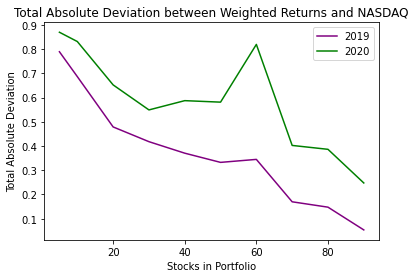

In [32]:
sn.lineplot(x = m_list, y= performanance19, label = "2019",  color = 'Purple')
sn.lineplot(x = m_list, y= performanance20, label = "2020",  color = 'green')
plt.title("Total Absolute Deviation between Weighted Returns and NASDAQ")
plt.xlabel("Stocks in Portfolio")
plt.ylabel("Total Absolute Deviation")


- We can observe that the overall absolute deviation is consistently lowering until there are 50 stocks in the portfolio for both 2019 and 2020. 

- With 60 equities in the portfolio, we begin to notice declining returns as a result of adding additional stocks to the portfolio. This shift is considerably more visible in the 2020 graph. This is due to the model utilizing weights from 2019.

- After 60 stocks, the divergence from the index fund begins to decline again, eventually becoming steady in 2020 when the number of stocks in the portfolio is between 90 and 100.

In [33]:
print("For 2019,",(pd.Series(cumret19).idxmax())*10, "stocks are needed to get the max cumulative value of", max(cumret19))
print("For 2020,",(pd.Series(cumret20).idxmax())*10, "stocks are needed to get the max cumulative value of", max(cumret20))

For 2019, 70 stocks are needed to get the max cumulative value of 145.2142667616713
For 2020, 30 stocks are needed to get the max cumulative value of 134.86185386723716


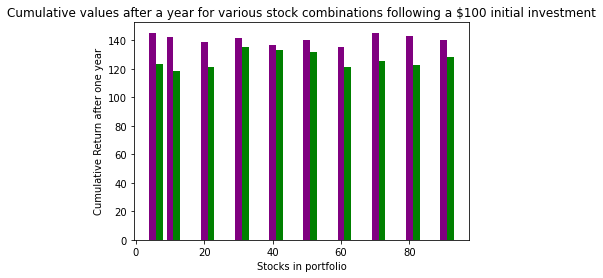

In [34]:
width=2
plt.bar(np.array(m_list), cumret19, width, label = '2019',  color = 'purple')
plt.bar(np.array(m_list)+width, cumret20, width,  color = 'green')
plt.xlabel('Stocks in portfolio')
plt.ylabel('Cumulative Return after one year')
plt.title('Cumulative values after a year for various stock combinations following a $100 initial investment')
plt.show()

### Question-4 : Using MIP method to compute the optimized weights 

In [35]:
length_yvars = len(return_stock19) 
weight_x = return_stock19.shape[1]-1
stock_chooser = return_stock19.shape[1]-1
obj_wt = np.array([1]*length_yvars + [0]*weight_x+ [0]*stock_chooser ) 
stock_returns19_all_funds = return_stock19.drop(['NDX'], axis = 1).to_numpy()
obj_wt.shape
q = return_stock19.loc[:,'NDX'].to_numpy()
M = 1
A_weight = np.zeros((2*length_yvars + weight_x+2 ,len(obj_wt)))

In [36]:
def MIP_Solver(m_input,df):
    length_yvars = len(df) 
    weight_x = df.shape[1]-1
    stock_chooser = df.shape[1]-1
    obj_wt = np.array([1]*length_yvars + [0]*weight_x+ 
                      [0]*stock_chooser ) 
    stock_returns19_all_funds = df.drop(['NDX'], axis = 1).to_numpy()
    
    q = df.loc[:,'NDX'].to_numpy()
    M = 1
    A_weight = np.zeros((2*length_yvars + weight_x+2 ,len(obj_wt)))
    A_weight[0:length_yvars,0:length_yvars] = np.identity(length_yvars) # First 250 constraints
    A_weight[0:length_yvars,length_yvars:length_yvars+weight_x] = stock_returns19_all_funds # Next 250 constraints
    A_weight[length_yvars:2*length_yvars,0:length_yvars] = np.identity(length_yvars)
    A_weight[length_yvars:2*length_yvars,length_yvars:length_yvars+weight_x] = stock_returns19_all_funds*-1 # Next 100 constraints

    i = 0
    for row_number in range(2*length_yvars, 2*length_yvars+weight_x):
        A_weight[row_number][length_yvars+i]=1
        A_weight[row_number][length_yvars+weight_x+i]=-1*M
        i = i+1

    A_weight[-2][-1*stock_chooser:] = 1 # Last 1 constraint to make sure that indicator variables add up to stocks to pick
    A_weight[-1][length_yvars: length_yvars+weight_x] = 1 # Last 1 constraint to make the weights as 1
    
    
    m = m_input
    b_weight = np.array(list(q) + list(-1*q) + [0]*weight_x + [m]*1 +[1]*1)
    direction_weight = np.array(['>']*length_yvars*2 + ['<']*weight_x +['=']*2) # Sense Array
        
    ## Optimization
    var_num = len(obj_wt)
    WeightMod = gp.Model()
    WeightMod_x = WeightMod.addMVar(var_num,vtype=['C']*length_yvars + ['C']*weight_x +['B']*stock_chooser) 
    WeightMod_con = WeightMod.addMConstrs(A_weight, WeightMod_x, direction_weight,b_weight)
    WeightMod.setMObjective(None,obj_wt,0,sense=gp.GRB.MINIMIZE)
    WeightMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    WeightMod.Params.timeLimit = gurobi_time_limit
    WeightMod.optimize()
    
    return WeightMod_x.x[length_yvars: length_yvars+weight_x]


In [37]:
'''
This runs for 8-9 hrs. Uncomment it when you want to calculte weights using MIP.

'''
# performanance19_method2 = []
# perf20_method2 = []
# for i in range(10,110,10): 
#     stock_choices = return_stock19.columns[1:]
#     Indexweights = MIP_Solver(i,return_stock19)
#     perf20_method2.append(perform_measure(return_stock20,stock_choices,Indexweights))
#     performanance19_method2.append(perform_measure(return_stock19,stock_choices,Indexweights))

# pd.DataFrame(perf20_method2).to_csv("2020.csv")
# pd.DataFrame(performanance19_method2).to_csv("2019.csv")

'\nThis runs for 8-9 hrs. Uncomment it when you want to calculte weights using MIP.\n\n'

<Figure size 1080x576 with 0 Axes>

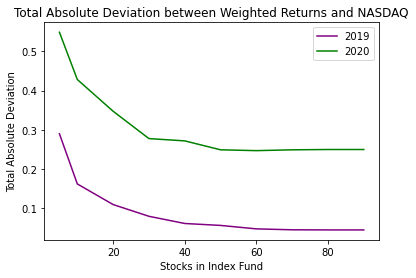

<Figure size 1080x576 with 0 Axes>

In [38]:
performanance19_method2 = pd.read_csv('2019.csv')
perf20_method2 = pd.read_csv('2020.csv')
sn.lineplot(x = m_list, y= performanance19_method2['0'], label = "2019", color='purple')
sn.lineplot(x = m_list, y= perf20_method2['0'], label = "2020", color='green')
plt.title("Total Absolute Deviation between Weighted Returns and NASDAQ")
plt.xlabel("Stocks in Index Fund")
plt.ylabel("Total Absolute Deviation")
plt.figure(figsize = (15,8))

- From the above graph, it is evident that the second method is much more accurate in tracking NASDAQ. Even at 5 stocks in the portfolio, the deviation in 2020 is near 0.45, whereas in the old method, it was over 0.85.

- The graph starts to get stable earlier at 60 stocks in the portfolio (both in 2019 and 2020). The final value of the deviation in 2020 is very similar to the value of deviation obtained in the old method, but the optimal number of stocks is much lesser. In this method, the optimal stocks is 40.

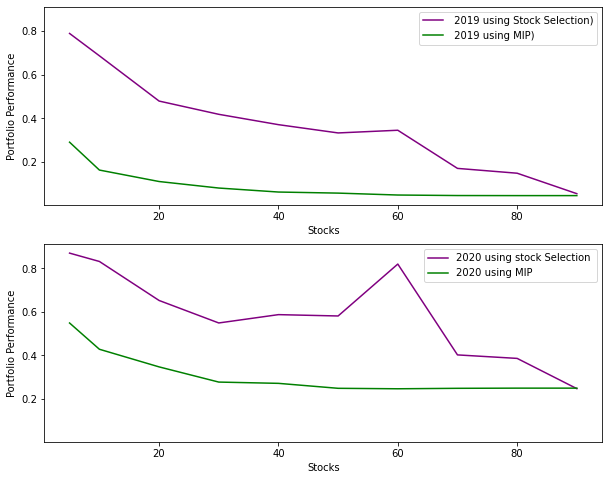

In [39]:
# Plot Performance vs Number of Stocks for both Methods

fig, (ax1, ax2) = plt.subplots(figsize = (10,8), sharey = True, nrows = 2, ncols = 1)

ax1.plot( m_list, performanance19, color='purple' ,label = ' 2019 using Stock Selection)')
ax1.plot(m_list, performanance19_method2['0'], color='green' ,label = ' 2019 using MIP)')
ax1.set_xlabel('Stocks')
ax1.set_ylabel('Portfolio Performance')
ax1.legend()

ax2.plot( m_list, performanance20, label = "2020 using stock Selection ", color='purple')
ax2.plot(m_list , perf20_method2['0'], label = "2020 using MIP", color='green' )
ax2.set_xlabel('Stocks')
ax2.set_ylabel('Portfolio Performance')
ax2.legend()
plt.show()

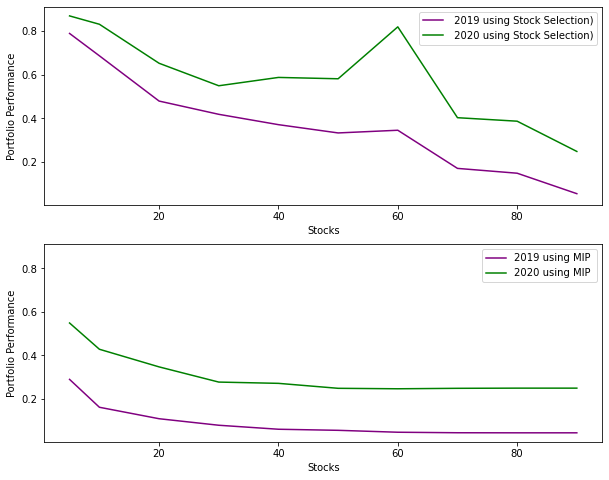

In [40]:
# Plot Performance vs Number of Stocks for both Methods

fig, (ax1, ax2) = plt.subplots(figsize = (10,8), sharey = True, nrows = 2, ncols = 1)

ax1.plot( m_list, performanance19, color='purple' ,label = ' 2019 using Stock Selection)')
ax1.plot(m_list, performanance20, color='green' ,label = ' 2020 using Stock Selection)')
ax1.set_xlabel('Stocks')
ax1.set_ylabel('Portfolio Performance')
ax1.legend()


ax2.plot( m_list, performanance19_method2['0'], label = "2019 using MIP ", color='purple')
ax2.plot(m_list , perf20_method2['0'], label = "2020 using MIP", color='green' )
ax2.set_xlabel('Stocks')
ax2.set_ylabel('Portfolio Performance')
ax2.legend()


plt.show()

### Final Recommendation
- The plot above shows that Method 2 performs better on the 2020 data. The performance of both approaches is comparable, but Method 1 has a lot more volatility since the loss changes with a larger magnitude.
- Method 2 is better, we advocate picking 40 stocks to model the NASDAQ-100 index and modeling the optimization to immediately compute the weights without first selecting the stocks, i.e., using the Second Method in the future. We may enhance our model by determining the cost of adding additional stocks to our portfolio and include that cost into our optimization restrictions.